To understand how GAN works, consider a toy example of trying to model the sine wave (x1, x2) where x1 is the x axis and x2 is the y axis. i.e x2 = sin(x1)

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import math

In [6]:
torch.manual_seed(111)

In [14]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])
# Since GANs make use of unsupervised learning techniques, the label don't mean anything. They are not used at all. This is there
# because pytorch's data loader requires tensor of training set along with its labels.
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

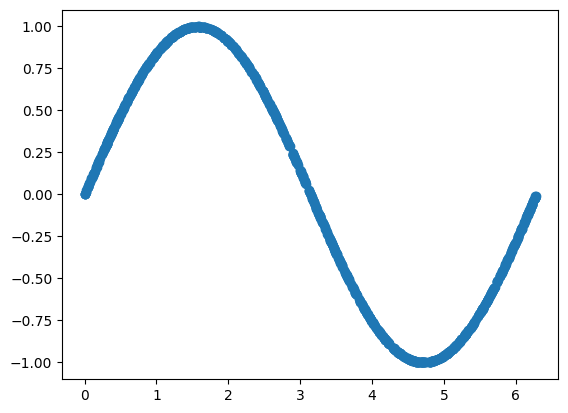

In [15]:
plt.plot(train_data[:, 0], train_data[:, 1], 'o')

In [17]:
# create a pytorch data loader
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

In [18]:
'''A discriminator is a neural network that takes in a sample and tries to classify it as real or fake.
It is trained to output 1 for real samples and 0 for fake samples.'''
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256), # 2 input features, 256 hidden units
            nn.ReLU(), # ReLU activation function
            nn.Dropout(0.3), # Dropout layer
            nn.Linear(256, 128), # 256 inputs from last layer, 128 hidden units
            nn.ReLU(), # ReLU activation function
            nn.Dropout(0.3), # Dropout layer
            nn.Linear(128, 64), # 128 inputs from last layer, 64 hidden units
            nn.ReLU(), # ReLU activation function
            nn.Dropout(0.3), # Dropout layer
            nn.Linear(64, 1), # 64 inputs from last layer, 1 output
            nn.Sigmoid() # Sigmoid activation function
        )
    
    def forward(self, x):
        return self.model(x)

'''A generator is a neural network that takes in a random noise vector and 
tries to generate a sample that looks like the real samples.'''
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16), # 2 input features, 16 hidden units
            nn.ReLU(), # ReLU activation function
            nn.Linear(16, 32), # 16 inputs from last layer, 32 hidden units
            nn.ReLU(), # ReLU activation function
            nn.Linear(32, 2), # 32 inputs from last layer, 2 output
        )
    def forward(self, x):
        return self.model(x)


# create a discriminator and a generator
discriminator = Discriminator()
generator = Generator()

In [49]:
lr = 0.001
num_epochs = 50
loss_function = nn.BCELoss() # Binary Cross Entropy Loss
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

### Finally, implement the training loop

In [50]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        d_output = discriminator(all_samples)
        d_loss = loss_function(d_output, all_samples_labels)
        d_loss.backward()
        d_optimizer.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        d_output_generated = discriminator(generated_samples)
        g_loss = loss_function(d_output_generated, real_samples_labels)
        g_loss.backward()
        g_optimizer.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch}, D loss: {d_loss.item()}, G loss: {g_loss.item()}")

Epoch: 0, D loss: 0.6951332688331604, G loss: 0.6836972236633301
Epoch: 10, D loss: 0.6349833011627197, G loss: 0.9663444757461548
Epoch: 20, D loss: 0.6800013780593872, G loss: 0.7060121297836304
Epoch: 30, D loss: 0.6961297392845154, G loss: 0.6986485123634338
Epoch: 40, D loss: 0.6835516095161438, G loss: 0.749186635017395


### Let's see the data generated by GAN

In [53]:
latent_space_samples = torch.randn((100, 2))
generated_samples = generator(latent_space_samples)

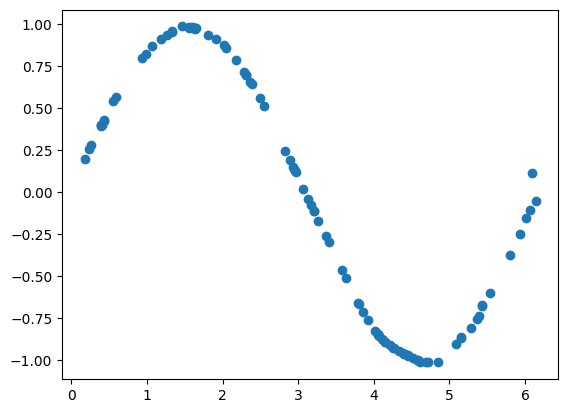

In [54]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], 'o')